In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2.8.0
1008

Denim : 648
Wool : 360


([0, 1], <a list of 2 Text major ticklabel objects>)

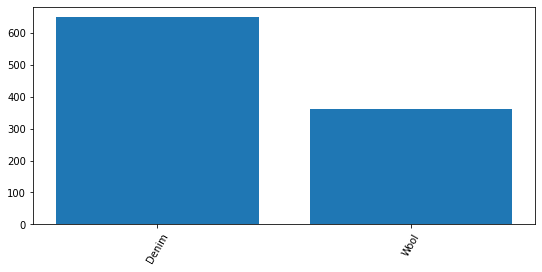

In [ ]:
#based of https://www.tensorflow.org/tutorials/load_data/images
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import re

print(tf.__version__)
import pathlib

path = "/content/drive/MyDrive/fabric_classification/Fabrics_simple"
#path = "C:/Users/Startklar/Documents/Computer Science/Uni Year 3/Term 2/Individual Project/Farbic classification/Fabrics_simple"
data_dir = pathlib.Path(path)

subfiles = "/*/*.png"

image_count = len(list(data_dir.glob('*'+subfiles)))
print(str(image_count) + "\n")

Denim = list(data_dir.glob('Denim'+subfiles))
Wool = list(data_dir.glob('Wool'+subfiles))

fabrics = {'Denim' : Denim,
           'Wool' : Wool}

farbic_names = []
fabric_counts = []
for fabric in list(fabrics.keys()):
    farbic_names.append(fabric)
    fabric_counts.append(len(fabrics[fabric]))
    print(f"{fabric} : {len(fabrics[fabric])}")

fabric_dict = {
    'Fabric' : farbic_names,
    'Count' : fabric_counts
}
                  
import pandas as pd
import matplotlib.pyplot as plt

fabric_df = pd.DataFrame(fabric_dict)

plt.figure(figsize=(9,4))
plt.bar(x=fabric_df['Fabric'],
        height=fabric_df['Count'])
plt.xticks(rotation=60)

In [ ]:
batch_size = 32
img_height = 400
img_width = 400
img_size = (img_height, img_width)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 1008 files belonging to 2 classes.
Using 807 files for training.
Found 1008 files belonging to 2 classes.
Using 201 files for validation.
['Denim', 'Wool']


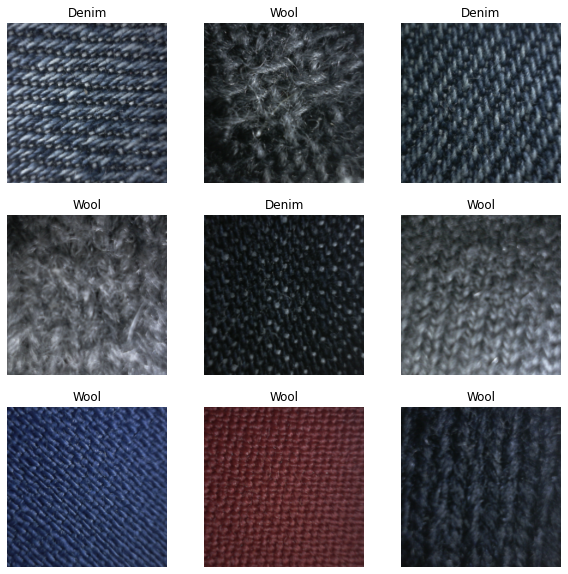

In [ ]:
#based of https://www.tensorflow.org/tutorials/load_data/images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

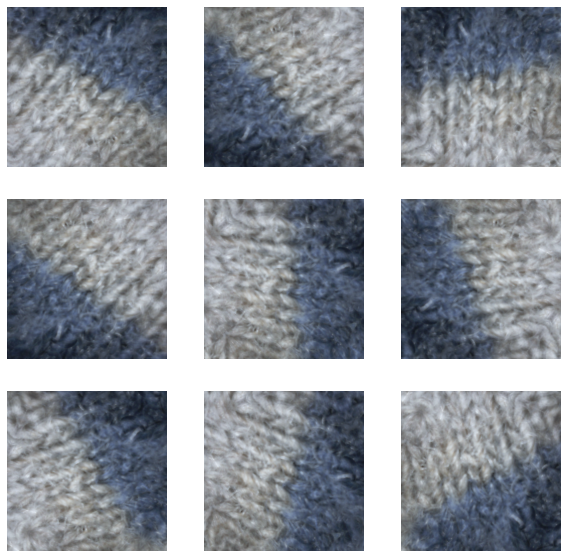

In [ ]:
#data augmentation based of https://keras.io/examples/vision/image_classification_from_scratch/

#the augmentations to make
data_augmentation = tf.keras.Sequential(
    [
        #tf.keras.layers.RandomFlip("horizontal"),
        #tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.5)
    ]
)

#visualize the effect of the augmentations on a sample image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#apply augmentation to the training data
#augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
#based of https://www.tensorflow.org/tutorials/load_data/images
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
#X = (32, 400, 400, 3) 32images, 400*400, color channels (r,g,b)
#Y = (32,)

(32, 400, 400, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Epoch 1/60
26/26 [==============================] - ETA: 0s - loss: 1.2441 - accuracy: 0.5762
Epoch 1: val_accuracy improved from -inf to 0.69652, saving model to /s_model_Aug_NoOpt.h5
26/26 [==============================] - 56s 2s/step - loss: 1.2441 - accuracy: 0.5762 - val_loss: 0.6593 - val_accuracy: 0.6965
Epoch 2/60
25/26 [===========================>..] - ETA: 0s - loss: 0.6396 - accuracy: 0.6187
Epoch 2: val_accuracy improved from 0.69652 to 0.74627, saving model to /s_model_Aug_NoOpt.h5
26/26 [==============================] - 2s 81ms/step - loss: 0.6397 - accuracy: 0.6183 - val_loss: 0.6110 - val_accuracy: 0.7463
Epoch 3/60
25/26 [===========================>..] - ETA: 0s - loss: 0.6175 - accuracy: 0.6625
Epoch 3: val_accuracy did not improve from 0.74627
26/26 [==============================] - 2s 71ms/step - loss: 0.6182 - accuracy: 0.6617 - val_loss: 0.5523 - val_accuracy: 0.7313
Epoch 4/60
25/26 [===========================>..] - ETA: 0s - loss: 0.6007 - accuracy: 0.6837

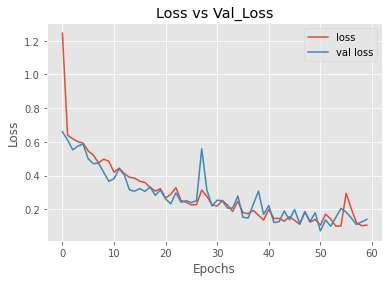

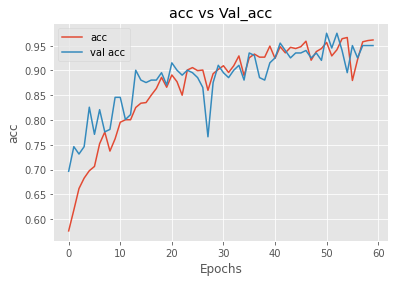

In [ ]:
#based of https://www.tensorflow.org/tutorials/load_data/images
num_classes = 2

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#based on https://towardsdatascience.com/ai-for-textiles-convolutional-neural-network-based-fabric-structure-classifier-c0db5433501d
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = '/s_model_Aug_NoOpt.h5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
with tf.device('/gpu:0'):
    hist = model.fit(train_ds, 
                    validation_data = val_ds, 
                    epochs = 50, 
                    verbose = 1, 
                    callbacks = [checkpoint])

model.summary()

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label = 'acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

(201, 2)
(201,)
(201,)
[[136   4]
 [  6  55]]


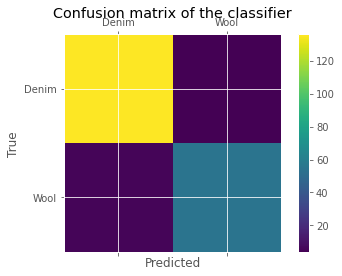

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_pred = model.predict(val_ds)#X
predicted_categories = tf.argmax(y_pred, axis=1)#X
true_categories = tf.concat([y for x, y in val_ds], axis=0)#y

print(y_pred.shape)
print(predicted_categories.shape)
print(true_categories.shape)

cm = confusion_matrix(true_categories, predicted_categories)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#based of https://keras.io/examples/vision/image_classification_from_scratch/
imgSize = (img_height, img_width)
img = tf.keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/fabric_classification/Fabrics_simple/Wool/7/im_1.png", target_size=imgSize
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

pred = model.predict(img_array)
print(np.round(pred[0:1], 2))
print(pred)
pred_val = np.argmax(pred,axis=1)
print(class_names)
print(f"This image is {pred_val}.")

[[-24.53  12.02]]
[[-24.526657  12.020391]]
['Denim', 'Wool']
This image is [1].
